The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0
!pip install -U mxnet-cu112==1.9.1


# Neural Style Transfer

If you are a photography enthusiast,
you may be familiar with the filter.
It can change the color style of photos
so that landscape photos become sharper
or portrait photos have whitened skins.
However,
one filter usually only changes
one aspect of the photo.
To apply an ideal style
to a photo,
you probably need to
try many different filter combinations.
This process is
as complex as tuning the hyperparameters of a model.



In this section, we will
leverage layerwise representations of a CNN
to automatically apply the style of one image
to another image, i.e., *style transfer* :cite:`Gatys.Ecker.Bethge.2016`.
This task needs two input images:
one is the *content image* and
the other is the *style image*.
We will use neural networks
to modify the content image
to make it close to the style image in style.
For example,
the content image in :numref:`fig_style_transfer` is a landscape photo taken by us
in Mount Rainier National Park in the suburbs of Seattle, while the style image is an oil painting
with the theme of autumn oak trees.
In the output synthesized image,
the oil brush strokes of the style image
are applied, leading to more vivid colors,
while preserving the main shape of the objects
in the content image.

![Given content and style images, style transfer outputs a synthesized image.](../img/style-transfer.svg)
:label:`fig_style_transfer`

## Method

:numref:`fig_style_transfer_model` illustrates
the CNN-based style transfer method with a simplified example.
First, we initialize the synthesized image,
for example, into the content image.
This synthesized image is the only variable that needs to be updated during the style transfer process,
i.e., the model parameters to be updated during training.
Then we choose a pretrained CNN
to extract image features and freeze its
model parameters during training.
This deep CNN uses multiple layers
to extract
hierarchical features for images.
We can choose the output of some of these layers as content features or style features.
Take :numref:`fig_style_transfer_model` as an example.
The pretrained neural network here has 3 convolutional layers,
where the second layer outputs the content features,
and the first and third layers output the style features.

![CNN-based style transfer process. Solid lines show the direction of forward propagation and dotted lines show backward propagation. ](../img/neural-style.svg)
:label:`fig_style_transfer_model`

Next, we calculate the loss function of style transfer through forward propagation (direction of solid arrows), and update the model parameters (the synthesized image for output) through backpropagation (direction of dashed arrows).
The loss function commonly used in style transfer consists of three parts:
(i) *content loss* makes the synthesized image and the content image close in content features;
(ii) *style loss* makes the synthesized image and style image close in style features;
and (iii) *total variation loss* helps to reduce the noise in the synthesized image.
Finally, when the model training is over, we output the model parameters of the style transfer to generate
the final synthesized image.



In the following,
we will explain the technical details of style transfer via a concrete experiment.


## [**Reading the Content and Style Images**]

First, we read the content and style images.
From their printed coordinate axes,
we can tell that these images have different sizes.


[07:38:08] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


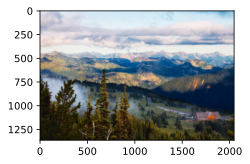

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

d2l.set_figsize()
content_img = image.imread('../img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

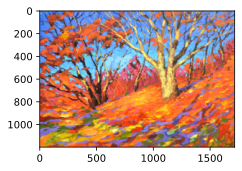

In [2]:
style_img = image.imread('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

## [**Preprocessing and Postprocessing**]

Below, we define two functions for preprocessing and postprocessing images.
The `preprocess` function standardizes
each of the three RGB channels of the input image and transforms the results into the CNN input format.
The `postprocess` function restores the pixel values in the output image to their original values before standardization.
Since the image printing function requires that each pixel has a floating point value from 0 to 1,
we replace any value smaller than 0 or greater than 1 with 0 or 1, respectively.


In [3]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return np.expand_dims(img.transpose(2, 0, 1), axis=0)

def postprocess(img):
    img = img[0].as_in_ctx(rgb_std.ctx)
    return (img.transpose(1, 2, 0) * rgb_std + rgb_mean).clip(0, 1)

## [**Extracting Features**]

We use the VGG-19 model pretrained on the ImageNet dataset to extract image features :cite:`Gatys.Ecker.Bethge.2016`.


In [4]:
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

In order to extract the content features and style features of the image, we can select the output of certain layers in the VGG network.
Generally speaking, the closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global information of the image. In order to avoid excessively
retaining the details of the content image in the synthesized image,
we choose a VGG layer that is closer to the output as the *content layer* to output the content features of the image.
We also select the output of different VGG layers for extracting local and global style features.
These layers are also called *style layers*.
As mentioned in :numref:`sec_vgg`,
the VGG network uses 5 convolutional blocks.
In the experiment, we choose the last convolutional layer of the fourth convolutional block as the content layer, and the first convolutional layer of each convolutional block as the style layer.
The indices of these layers can be obtained by printing the `pretrained_net` instance.


In [5]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

When extracting features using VGG layers,
we only need to use all those
from the input layer to the content layer or style layer that is closest to the output layer.
Let's construct a new network instance `net`, which only retains all the VGG layers to be
used for feature extraction.


In [6]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

Given the input `X`, if we simply invoke
the forward propagation `net(X)`, we can only get the output of the last layer.
Since we also need the outputs of intermediate layers,
we need to perform layer-by-layer computation and keep
the content and style layer outputs.


In [7]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

Two functions are defined below:
the `get_contents` function extracts content features from the content image,
and the `get_styles` function extracts style features from the style image.
Since there is no need to update the model parameters of the pretrained VGG during training,
we can extract the content and the style features
even before the training starts.
Since the synthesized image
is a set of model parameters to be updated
for style transfer,
we can only extract the content and style features of the synthesized image by calling the `extract_features` function during training.


In [8]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).copyto(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).copyto(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## [**Defining the Loss Function**]

Now we will describe the loss function for style transfer. The loss function consists of
the content loss, style loss, and total variation loss.

### Content Loss

Similar to the loss function in linear regression,
the content loss measures the difference
in content features
between the synthesized image and the content image via
the squared loss function.
The two inputs of the squared loss function
are both
outputs of the content layer computed by the `extract_features` function.


In [9]:
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

### Style Loss

Style loss, similar to content loss,
also uses the squared loss function to measure the difference in style between the synthesized image and the style image.
To express the style output of any style layer,
we first use the `extract_features` function to
compute the style layer output.
Suppose that the output has
1 example, $c$ channels,
height $h$, and width $w$,
we can transform this output into
matrix $\mathbf{X}$ with $c$ rows and $hw$ columns.
This matrix can be thought of as
the concatenation of
$c$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_c$,
each of which has a length of $hw$.
Here, vector $\mathbf{x}_i$ represents the style feature of channel $i$.

In the *Gram matrix* of these vectors $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, element $x_{ij}$ in row $i$ and column $j$ is the dot product of vectors $\mathbf{x}_i$ and $\mathbf{x}_j$.
It represents the correlation of the style features of channels $i$ and $j$.
We use this Gram matrix to represent the style output of any style layer.
Note that when the value of $hw$ is larger,
it likely leads to larger values in the Gram matrix.
Note also that the height and width of the Gram matrix are both the number of channels $c$.
To allow style loss not to be affected
by these values,
the `gram` function below divides
the Gram matrix by the number of its elements, i.e., $chw$.


In [10]:
def gram(X):
    num_channels, n = X.shape[1], d2l.size(X) // X.shape[1]
    X = X.reshape((num_channels, n))
    return np.dot(X, X.T) / (num_channels * n)

Obviously,
the two Gram matrix inputs of the squared loss function for style loss are based on
the style layer outputs for
the synthesized image and the style image.
It is assumed here that the Gram matrix `gram_Y` based on the style image has been precomputed.


In [11]:
def style_loss(Y_hat, gram_Y):
    return np.square(gram(Y_hat) - gram_Y).mean()

### Total Variation Loss

Sometimes, the learned synthesized image
has a lot of high-frequency noise,
i.e., particularly bright or dark pixels.
One common noise reduction method is
*total variation denoising*.
Denote by $x_{i, j}$ the pixel value at coordinate $(i, j)$.
Reducing total variation loss

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

makes values of neighboring pixels on the synthesized image closer.


In [12]:
def tv_loss(Y_hat):
    return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### Loss Function

[**The loss function of style transfer is the weighted sum of content loss, style loss, and total variation loss**].
By adjusting these weight hyperparameters,
we can balance among
content retention,
style transfer,
and noise reduction on the synthesized image.


In [13]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## [**Initializing the Synthesized Image**]

In style transfer,
the synthesized image is the only variable that needs to be updated during training.
Thus, we can define a simple model, `SynthesizedImage`, and treat the synthesized image as the model parameters.
In this model, forward propagation just returns the model parameters.


In [14]:
class SynthesizedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

Next, we define the `get_inits` function.
This function creates a synthesized image model instance and initializes it to the image `X`.
Gram matrices for the style image at various style layers, `styles_Y_gram`, are computed prior to training.


In [15]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## [**Training**]


When training the model for style transfer,
we continuously extract
content features and style features of the synthesized image, and calculate the loss function.
Below defines the training loop.


In [16]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs], ylim=[0, 20],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        if (epoch + 1) % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.8)
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

Now we [**start to train the model**].
We rescale the height and width of the content and style images to 300 by 450 pixels.
We use the content image to initialize the synthesized image.


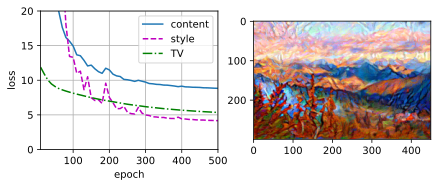

In [17]:
device, image_shape = d2l.try_gpu(), (450, 300)
net.collect_params().reset_ctx(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.9, 500, 50)

We can see that the synthesized image
retains the scenery and objects of the content image,
and transfers the color of the style image
at the same time.
For example,
the synthesized image has blocks of color like
those in the style image.
Some of these blocks even have the subtle texture of brush strokes.




## Summary

* The loss function commonly used in style transfer consists of three parts: (i) content loss makes the synthesized image and the content image close in content features; (ii) style loss makes the synthesized image and style image close in style features; and (iii) total variation loss helps to reduce the noise in the synthesized image.
* We can use a pretrained CNN to extract image features and minimize the loss function to continuously update the synthesized image as model parameters during training.
* We use Gram matrices to represent the style outputs from the style layers.


## Exercises

1. How does the output change when you select different content and style layers?
1. Adjust the weight hyperparameters in the loss function. Does the output retain more content or have less noise?
1. Use different content and style images. Can you create more interesting synthesized images?
1. Can we apply style transfer for text? Hint: you may refer to the survey paper by :citet:`10.1145/3544903.3544906`.


[Discussions](https://discuss.d2l.ai/t/378)
